In [58]:
from glob import glob
import os
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import cv2
import pure_cv as vc
from haskellian import iter as I, Iter, funcs as F, IsLeft
import scoresheet_models as sm

PATHS = sorted(glob('imgs/**/*', recursive=True))

### 1. Identify grid corners
- Fix `s` and `t` so that next steps are easier

**Note: the model shall only include the grid of moves, not extra rows or cols**

So, exclude the left of the first number column!

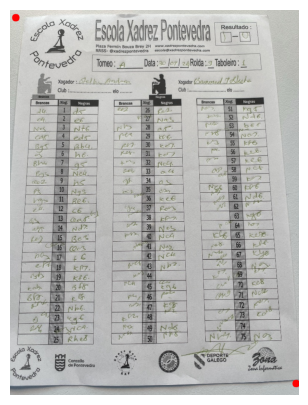

In [60]:
img = vc.imread('imgs/ponte2.jpg')
h, w = img.shape[:2]

T = np.array([0.02, 0.02])
S = np.array([0.97, 0.95])

sheet_w = w * S[0]
sheet_h = h * S[1]

tl = T*[w, h]
br = (S+T)*[w, h]

vc.show(vc.draw.vertices(img, [tl, br], radius=10))

### 2. Find box size and intra-block number width
- Relative box width
- Intra-block number width (if applicable)
- Number of rows (of boxes, not grid lines)
- The image will display all points in the first block. They should match exactly only by setting `BOX_WIDTH`, `INTRA_WIDTH` and `NUM_ROWS`

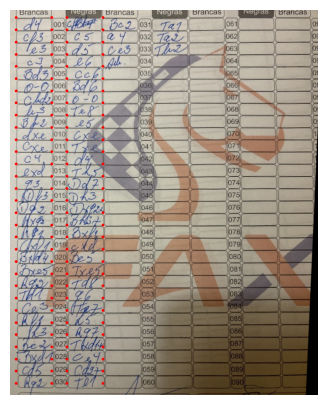

In [32]:
BOX_WIDTH = 0.12
INTRA_WIDTH: float | None = 0.05
NUM_ROWS = 30

def abs_box(box_w, num_rows):
  abs_box_w = box_w * sheet_w
  abs_box_h = sheet_h / num_rows
  return abs_box_w, abs_box_h

def abs_intra(intra_w = INTRA_WIDTH):
  return (intra_w or 0) * sheet_w

def block_points(top_left, box_w = BOX_WIDTH, intra_w = INTRA_WIDTH, num_rows = NUM_ROWS):
  abs_box_w, abs_box_h = abs_box(box_w, num_rows)
  abs_intra_w = abs_intra(intra_w)
  fst_l = np.array([top_left + [0, abs_box_h*i] for i in range(NUM_ROWS+1)])
  fst_r = fst_l + [abs_box_w, 0]
  snd_l = fst_r + [abs_intra_w or 0, 0]
  snd_r = snd_l + [abs_box_w, 0]
  return np.concatenate([fst_l, fst_r, snd_l, snd_r])

fst_block = block_points(tl)
vc.show(vc.draw.vertices(img, fst_block, radius=3))

### 3. Find inter-block space (if applicable)
The image shows the left points of the second block numbers. They should match exactly

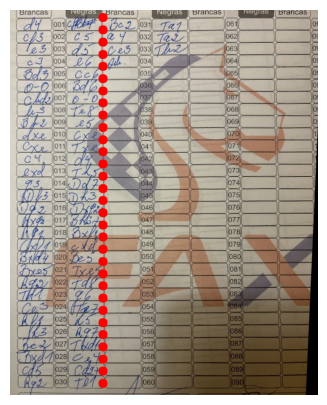

In [34]:
SPACE_W: float | None = None

abs_box_w, abs_box_h = abs_box(BOX_WIDTH, NUM_ROWS)
abs_intra_w = abs_intra()

def abs_space(space_w = SPACE_W):
  return (space_w or 0) * sheet_w

abs_space_w = abs_space()
second_block_tl = tl + [2*abs_box_w + abs_intra_w + abs_space_w, 0]
num_points = [second_block_tl + [0, abs_box_h*i] for i in range(NUM_ROWS+1)]
vc.show(vc.draw.vertices(img, num_points))

### 4. Find number box width

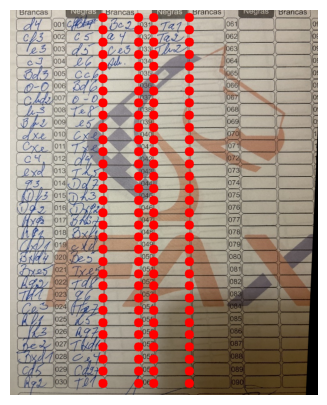

In [35]:
NUM_W: float | None = None

def abs_num(num_w = NUM_W):
  return (num_w or 0) * sheet_w
abs_num_w = abs_num()

second_block_points = block_points(second_block_tl + [abs_num_w, 0])
vc.show(vc.draw.vertices(img, second_block_points))

In [37]:
print('Current parameters:')
print(f'  - Box Width: {BOX_WIDTH}')
print(f'  - Intra Width: {INTRA_WIDTH}')
print(f'  - Space Width: {SPACE_W}')
print(f'  - Number Width: {NUM_W}')

Current parameters:
  - Box Width: 0.12
  - Intra Width: 0.05
  - Space Width: None
  - Number Width: None


NUM BLOCKS: 4


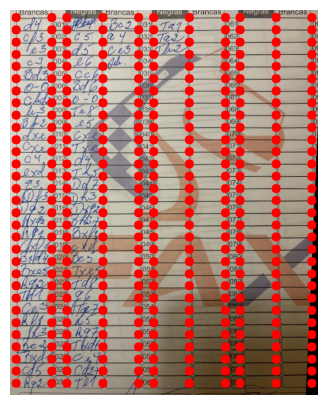

In [48]:
NUM_BLOCKS = 4
FINAL_BOX_WIDTH = BOX_WIDTH
FINAL_INTRA_W = INTRA_WIDTH
FINAL_SPACE_W = SPACE_W
FINAL_NUM_W = NUM_W

abs_box_w, abs_box_h = abs_box(FINAL_BOX_WIDTH, NUM_ROWS)
abs_space_w = abs_space(FINAL_SPACE_W)
abs_num_w = abs_num(FINAL_NUM_W)
abs_intra_w = abs_intra(FINAL_INTRA_W)

block_tls = [tl + [i*(2*abs_box_w + abs_space_w + abs_intra_w + abs_num_w), 0] for i in range(NUM_BLOCKS)]
all_points = I.flatten(block_points(block_tl, FINAL_BOX_WIDTH, FINAL_INTRA_W, NUM_ROWS) for block_tl in block_tls).sync()

print('NUM BLOCKS:', NUM_BLOCKS)
vc.show(vc.draw.vertices(img, all_points))

### 6. Result

Model: boxWidth=0.12 rows=30 columns=[None, 0.05, None, None, 0.05, None, None, 0.05, None]


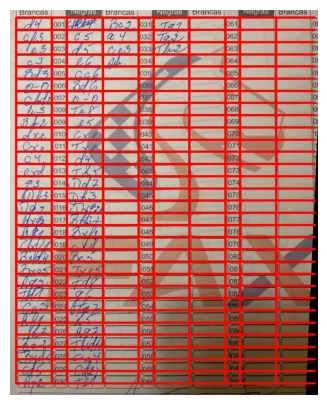

In [53]:
columns = []
for i in range(NUM_BLOCKS-1):
  columns.append(None)
  if INTRA_WIDTH is not None:
    columns.append(INTRA_WIDTH)
  columns.append(None)
  
  if SPACE_W is not None:
    columns.append(SPACE_W)
  if NUM_W is not None:
    columns.append(NUM_W)

model = sm.Model(boxWidth=BOX_WIDTH, rows=NUM_ROWS, columns=columns)
print('Model:', model)
vc.show(sm.draw(img, model, s=S, t=T))

### 7. Visualize Extracted Boxes

In [ ]:
h, w = img.shape[:2]
cnts = sm.contours(model, tl=T, size=S) * [w, h]
boxes = vc.extract_contours(img, cnts)
vc.show(*boxes[:16], ncols=4, height=2)